Found 2 saddle points


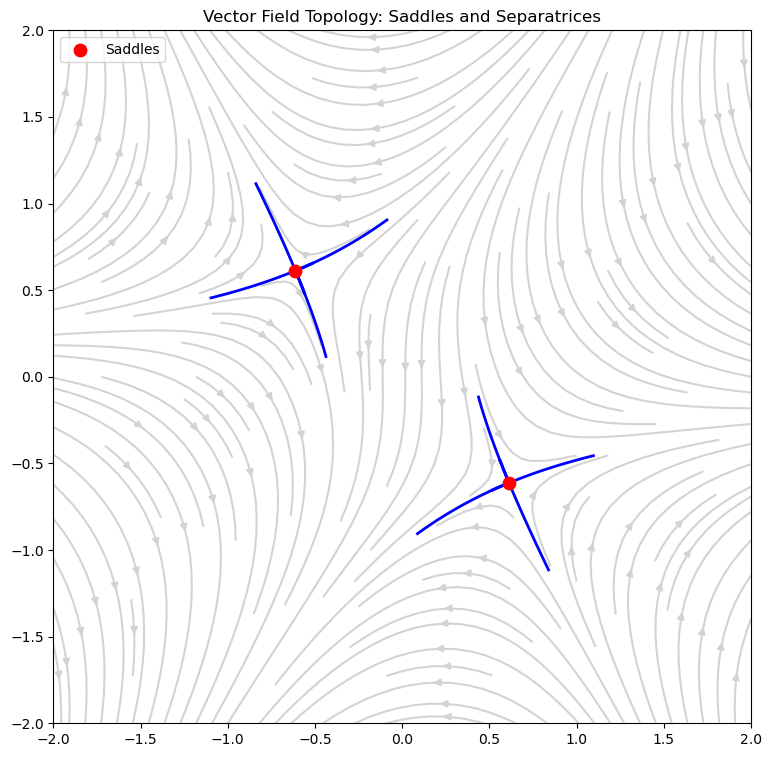

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
import numpy.linalg as LA
from shapely.geometry import LineString

# -------------------------------------------------
# 1. Create example velocity field WITH SADDLE
# -------------------------------------------------
nx, ny = 200, 200
x = np.linspace(-2, 2, nx)
y = np.linspace(-2, 2, ny)
X, Y = np.meshgrid(x, y)

# Streamfunction that has a saddle
psi = X**2 * Y - (Y**3)/3 + 0.75 * X

# Velocity components
u =  np.gradient(psi, y, axis=0)   # dψ/dy
v = -np.gradient(psi, x, axis=1)   # -dψ/dx


# -------------------------------------------------
# 2. Find critical points (u=0 & v=0)
# -------------------------------------------------
fig_tmp, ax_tmp = plt.subplots()
cs_u = ax_tmp.contour(x, y, u, levels=[0])
cs_v = ax_tmp.contour(x, y, v, levels=[0])
plt.close(fig_tmp)

def contour_to_lines(cs):
    lines = []
    # Works across newer matplotlib versions
    for seglist in cs.allsegs:        # list of contour levels
        for seg in seglist:           # each individual contour line
            if len(seg) > 2:          # need at least 2 points
                lines.append(LineString(seg))
    return lines

u_lines = contour_to_lines(cs_u)
v_lines = contour_to_lines(cs_v)

critical_points = []
for ul in u_lines:
    for vl in v_lines:
        inter = ul.intersection(vl)
        if inter.is_empty:
            continue
        if inter.geom_type == "Point":
            critical_points.append((inter.x, inter.y))

# Remove duplicates
critical_points = np.unique(np.round(critical_points, 4), axis=0)

# -------------------------------------------------
# 3. Compute Jacobian and classify saddles
# -------------------------------------------------
uy, ux = np.gradient(u, y, x)
vy, vx = np.gradient(v, y, x)

interp_ux = RegularGridInterpolator((y, x), ux)
interp_uy = RegularGridInterpolator((y, x), uy)
interp_vx = RegularGridInterpolator((y, x), vx)
interp_vy = RegularGridInterpolator((y, x), vy)
u_interp  = RegularGridInterpolator((y, x), u)
v_interp  = RegularGridInterpolator((y, x), v)

saddles = []

for xc, yc in critical_points:
    J = np.array([
        [interp_ux((yc, xc)), interp_uy((yc, xc))],
        [interp_vx((yc, xc)), interp_vy((yc, xc))]
    ])
    eigvals, eigvecs = LA.eig(J)

    if np.isreal(eigvals).all() and eigvals[0]*eigvals[1] < 0:
        saddles.append((xc, yc, eigvals.real, eigvecs.real))

print(f"Found {len(saddles)} saddle points")

# -------------------------------------------------
# 4. Integrate separatrices
# -------------------------------------------------
def velocity(t, XY):
    x0, y0 = XY
    return [
        float(u_interp((y0, x0))),
        float(v_interp((y0, x0)))
    ]

separatrices = []
eps = 1e-4

for xc, yc, eigvals, eigvecs in saddles:
    for i in range(2):
        vec = eigvecs[:, i]
        vec = vec / np.linalg.norm(vec)

        for sign in [+1, -1]:
            start = np.array([xc, yc]) + sign * eps * vec

            sol_f = solve_ivp(velocity, [0, 5], start, max_step=0.05)
            sol_b = solve_ivp(velocity, [0, -5], start, max_step=0.05)

            separatrices.append(sol_f.y)
            separatrices.append(sol_b.y)

# -------------------------------------------------
# 5. Plot results
# -------------------------------------------------
plt.figure(figsize=(9, 9))
plt.streamplot(x, y, u, v, density=1.5, color='lightgray')

# Saddles
sx = [s[0] for s in saddles]
sy = [s[1] for s in saddles]
plt.scatter(sx, sy, c='red', s=80, label='Saddles', zorder=5)

# Separatrices
for sep in separatrices:
    plt.plot(sep[0], sep[1], 'b', linewidth=2)

plt.title("Vector Field Topology: Saddles and Separatrices")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.legend()
plt.show()
